To improve our model's performance, we consider extracting additional features from the given dataset or even augmenting it with external data sources. Some possible extra features include:

In [ ]:
!pip install transformers
!pip install allennlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 54.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 29.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 83.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 730.2/730.2 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.3/776.3 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 71.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.2/248.2 kB 25.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 69.5

In [ ]:
import pandas as pd
import re
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
import string
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
from sklearn.preprocessing import StandardScaler
import spacy



In [ ]:
train = pd.read_csv('train.csv')

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def extract_features(df):
    # Length of the tweet
    df['tweet_length'] = df['text'].apply(lambda x: len(x))

    # Number of words in the tweet
    df['word_count'] = df['text'].apply(lambda x: len(x.split()))

    # Number of unique words in the text
    df['unique_word_count'] = df['text'].apply(lambda x: len(set(x.split())))

    # Number of stop words in the text
    df['stop_word_count'] = df['text'].apply(lambda x: len([word for word in x.split() if word.lower() in stop_words]))

    # Average character count in words
    df['mean_word_length'] = df['text'].apply(lambda x: sum(len(word) for word in x.split()) / len(x.split()) if len(x.split()) > 0 else 0)

    # Number of characters in the text
    df['char_count'] = df['text'].apply(lambda x: len(x))

    # Number of punctuations in the text
    df['punctuation_count'] = df['text'].apply(lambda x: len([char for char in x if char in string.punctuation]))

    # Number of hashtags in the text
    df['hashtag_count'] = df['text'].apply(lambda x: len(re.findall(r'#\w+', x)))


    # Number of hashtags, mentions, and URLs
    df['hashtags_count'] = df['text'].apply(lambda x: len(re.findall(r'#\w+', x)))
    df['mentions_count'] = df['text'].apply(lambda x: len(re.findall(r'@\w+', x)))
    df['urls_count'] = df['text'].apply(lambda x: len(re.findall(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', x)))

    # Presence of uppercase words or words in all caps
    df['uppercase_word_count'] = df['text'].apply(lambda x: len([word for word in x.split() if word.isupper()]))

    # Sentiment analysis (positive, negative, or neutral sentiment)
    df['sentiment'] = df['text'].apply(lambda x: TextBlob(x).sentiment.polarity)

    return df


In [ ]:
# Apply the feature extraction function
train = extract_features(train)

In [ ]:
train

,id,keyword,location,text,target,tweet_length,word_count,unique_word_count,stop_word_count,mean_word_length,char_count,punctuation_count,hashtag_count,hashtags_count,mentions_count,urls_count,uppercase_word_count,sentiment
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69,13,13,6,4.384615,69,1,1,1,0,0,1,0.000000
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38,7,7,0,4.571429,38,1,0,0,0,0,0,0.100000
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133,22,20,11,5.090909,133,3,0,0,0,0,0,-0.018750
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65,8,8,1,7.125000,65,2,1,1,0,0,0,0.000000
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88,16,15,7,4.500000,88,2,2,2,0,0,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,83,11,11,2,6.636364,83,5,0,0,0,1,0,0.000000
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,125,20,17,9,5.300000,125,5,0,0,2,0,0,0.150000
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,65,8,8,2,7.250000,65,11,0,0,0,1,2,0.000000
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,137,19,19,5,6.263158,137,5,0,0,0,0,0,-0.260417


In [ ]:
# Check for duplicate rows based on the 'text' column
duplicate_rows = train.duplicated(subset=['text'])

# Count the number of duplicate rows
num_duplicate_rows = duplicate_rows.sum()

# Print the number of duplicate rows
print(f"There are {num_duplicate_rows} duplicate rows based on the 'text' column.")


There are 110 duplicate rows based on the 'text' column.


In [ ]:
train[duplicate_rows].sort_values('text')


,id,keyword,location,text,target,tweet_length,word_count,unique_word_count,stop_word_count,mean_word_length,char_count,punctuation_count,hashtag_count,hashtags_count,mentions_count,urls_count,uppercase_word_count,sentiment
4299,6105,hellfire,?????? ??? ?????? ????????,#Allah describes piling up #wealth thinking it...,0,138,22,20,8,5.318182,138,6,5,5,0,0,0,0.0
4312,6123,hellfire,?????? ???? ??????,#Allah describes piling up #wealth thinking it...,1,138,22,20,8,5.318182,138,6,5,5,0,0,0,0.0
6366,9098,suicide%20bomb,Nigeria,#Bestnaijamade: 16yr old PKK suicide bomber wh...,1,140,16,14,2,7.812500,140,11,1,1,0,1,1,0.1
6373,9107,suicide%20bomb,Nigeria,#Bestnaijamade: 16yr old PKK suicide bomber wh...,1,140,16,14,2,7.812500,140,11,1,1,0,1,1,0.1
6392,9135,suicide%20bomb,Nigeria,#Bestnaijamade: 16yr old PKK suicide bomber wh...,1,140,16,14,2,7.812500,140,11,1,1,0,1,1,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3461,4952,exploded,NaN,that exploded &amp; brought about the\nbeginni...,0,137,21,19,8,5.571429,137,5,0,0,0,0,0,0.0
6103,8714,sinking,NaN,that horrible sinking feeling when youÛªve be...,0,129,25,23,15,4.200000,129,0,0,0,0,0,1,-0.4
6094,8702,sinking,NaN,that horrible sinking feeling when youÛªve be...,0,129,25,23,15,4.200000,129,0,0,0,0,0,1,-0.4
6123,8739,sinking,MA,that horrible sinking feeling when youÛªve be...,1,129,25,23,15,4.200000,129,0,0,0,0,0,1,-0.4


In [ ]:
# Group the data by the unique observations
grouped_data = train.groupby('text')

# Get the mode of the target values for each group
target_modes = grouped_data['target'].apply(lambda x: x.mode()[0])

# Combine the unique observations with their corresponding target modes
train = pd.concat([grouped_data.first().reset_index(), target_modes.reset_index(drop=True)], axis=1)

In [ ]:
# Get the column names
column_names = train.columns.tolist()

# Find the first 'target' column
first_target_index = column_names.index('target')

# Remove the first 'target' column from the list of column names
column_names.pop(first_target_index)

# Reassign the DataFrame with the updated column names
train = train[column_names]

In [ ]:
train = train.iloc[:,:18]

In [ ]:
train

,text,id,keyword,location,tweet_length,word_count,unique_word_count,stop_word_count,mean_word_length,char_count,punctuation_count,hashtag_count,hashtags_count,mentions_count,urls_count,uppercase_word_count,sentiment,target
0,! Residents Return To Destroyed Homes As Washi...,10517,wildfire,None,92,12,12,3,6.750000,92,6,0,0,0,1,0,0.000000,1
1,# handbags Genuine Mulberry Antony Cross Body ...,1383,body%20bag,None,137,18,18,0,6.611111,137,12,0,0,0,1,1,0.087500,0
2,#360WiseNews : China's Stock Market Crash: Are...,8314,rubble,London,95,13,13,4,6.384615,95,10,1,1,0,1,0,0.000000,1
3,#360WiseNews : China's Stock Market Crash: Are...,8334,rubble,Made Here In Detroit,95,13,13,4,6.384615,95,10,1,1,0,1,0,0.000000,1
4,#360WiseNews : China's Stock Market Crash: Are...,8301,rubble,"Accra,Ghana",95,13,13,4,6.384615,95,10,1,1,0,1,0,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7498,Û÷We Can HelpÛª Says Denver Firefighter Work...,5420,first%20responders,"Portage, IN / Worldwide",104,13,13,2,7.076923,104,5,0,0,0,1,0,0.250000,1
7499,å_? New Ladies Shoulder Tote #Handbag Faux Lea...,1414,body%20bag,Paignton,130,16,16,0,7.187500,130,14,2,2,0,2,0,0.068182,0
7500,å¤} New Ladies Shoulder Tote #Handbag Faux Lea...,1394,body%20bag,"California, USA",139,18,18,0,6.777778,139,14,2,2,0,2,1,0.068182,0
7501,å¬'Only the sea knows how many are dead' @MSF_...,4006,disaster,None,135,19,19,7,6.105263,135,10,1,1,1,1,0,0.075000,1


In [ ]:
import numpy as np
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
import re
from nltk.stem import WordNetLemmatizer


# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()
nltk.download('punkt')
nltk.download('wordnet')
# Function to preprocess text
def preprocess(text):
    # Lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)

    # Remove mentions
    text = re.sub(r"@\w+", '', text)

    # Remove HTML tags
    text = re.sub(r"<.*?>", '', text)

    # Remove punctuations
    text = "".join([char for char in text if char not in string.punctuation])

    # Tokenize
    words = word_tokenize(text)

    # Lemmatize
    words = [lemmatizer.lemmatize(word) for word in words]

    # Remove numbers
    words = [re.sub(r"\d+", "<number>", word) for word in words]

    return words

# Apply preprocessing to the 'text' column
train['tokenized_text'] = train['text'].apply(preprocess)
train['processed_text'] = train['tokenized_text'].apply(lambda tokens: ' '.join(tokens))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### LDA FOR TOPICS

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer

# Vectorize the text using TF-IDF
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(train['text'])

# Apply LDA for topic modeling
n_topics = 19  # Adjust the number of topics as needed
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
lda.fit(X)

# Assign a topic to each tweet
train['topic'] = lda.transform(X).argmax(axis=1)

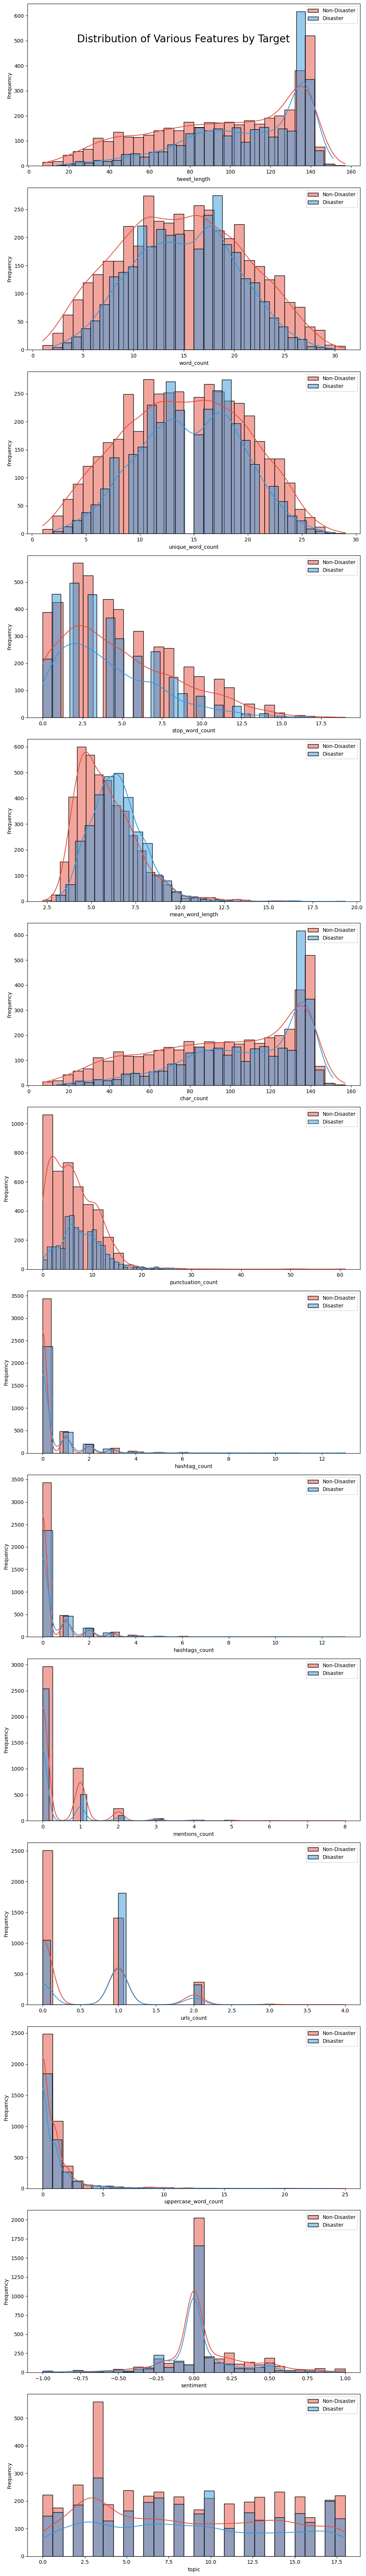

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
# Select columns to plot
cols_to_plot = ['tweet_length', 'word_count', 'unique_word_count', 'stop_word_count', 'mean_word_length',
                'char_count', 'punctuation_count', 'hashtag_count', 'hashtags_count', 'mentions_count',
                'urls_count', 'uppercase_word_count', 'sentiment', 'topic']

# Determine number of rows needed for subplots
num_rows = len(cols_to_plot)

# Create subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=1, figsize=(10, 5*num_rows), sharey=False)

# Plot each column
for i, col in enumerate(cols_to_plot):
    # Plot distribution of feature for target=0 (Non-Disaster Tweets)
    sns.histplot(train[train['target'] == 0][col], bins=30, ax=axes[i], color='#e74c3c', kde=True, label='Non-Disaster', alpha = 0.5)
    
    # Plot distribution of feature for target=1 (Disaster Tweets)
    sns.histplot(train[train['target'] == 1][col], bins=30, ax=axes[i], color='#3498db', kde=True, label='Disaster', alpha=0.5)

    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')
    axes[i].legend()

# Set common title
fig.suptitle('Distribution of Various Features by Target', fontsize=20)

# Adjust spacing between subplots
fig.tight_layout()

# Show the plot
plt.show()


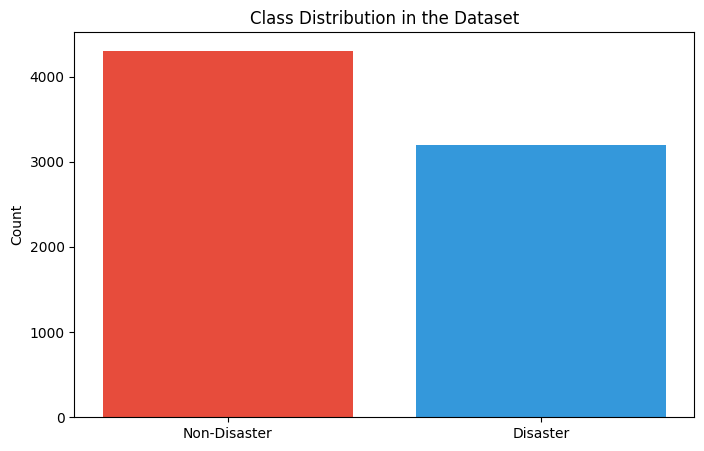

In [ ]:
class_counts = train['target'].value_counts()

plt.figure(figsize=(8, 5))
plt.bar(class_counts.index, class_counts.values, color=['#e74c3c', '#3498db'])
plt.xticks([0, 1], ['Non-Disaster', 'Disaster'])
plt.ylabel('Count')
plt.title('Class Distribution in the Dataset')
plt.show()


In [ ]:
pd.set_option('display.max_colwidth', None)

# Get a DataFrame with the true and predicted values
results = pd.DataFrame({'True': y_true, 'Predicted': y_pred, 'Text': X_val['text'].values})

# Add a column for whether the prediction was correct
results['Correct'] = results['True'] == results['Predicted']

# Get some examples where the prediction was incorrect
incorrect_examples = results[results['Correct'] == False].sample(15)

# Display the incorrect examples
pd.DataFrame(incorrect_examples)


,True,Predicted,Text,Correct
613,0,1,Snowstorm planned outside #Rome's St Mary Major tonight - annual occasion artificial snow remembering summer snow in 358 AD on same spot.,False
220,0,1,Earthquake drill ??????,False
946,1,0,From recycling to only using non-hazardous chemicals Holland 1916 continually strives to maintain an eco-friendly existence.,False
566,1,0,#Obama signed up to a deal that far from making the world a safer place http://t.co/E0luGBL6pb via @upi #Iran #Nuclear #IranNuclearDeal,False
964,1,0,CIVIL WAR GENERAL BATTLE BULL RUN HERO COLONEL 2nd NEW HAMPSHIRE LETTER SIGNED ! http://t.co/Ot0tFFpBYB http://t.co/zaRBwep9LD,False
351,1,0,@argentings WE COULD HAVE HAD IT AAAAAAALLLL IÛªm not even on that season and IÛªm devastated,False
524,1,0,Ignition Knock (Detonation) Sensor-Senso BECK/ARNLEY 158-0853 http://t.co/OdMx36WDhM http://t.co/gAHeUjRUJu,False
90,1,0,If Trillion crosses the line a 3rd time he does a field-wide attack that does instant kill damage,False
813,0,1,#Vegetarian #Vegan Video shows arsonist torching popular BK restaurant Strictly Vegetarian... http://t.co/kxpLYoM9RR #GoVegan #UniteBlue,False
257,1,0,Do babies actually get electrocuted from wall sockets? I'm wondering how I and those before me survived childhood.,False


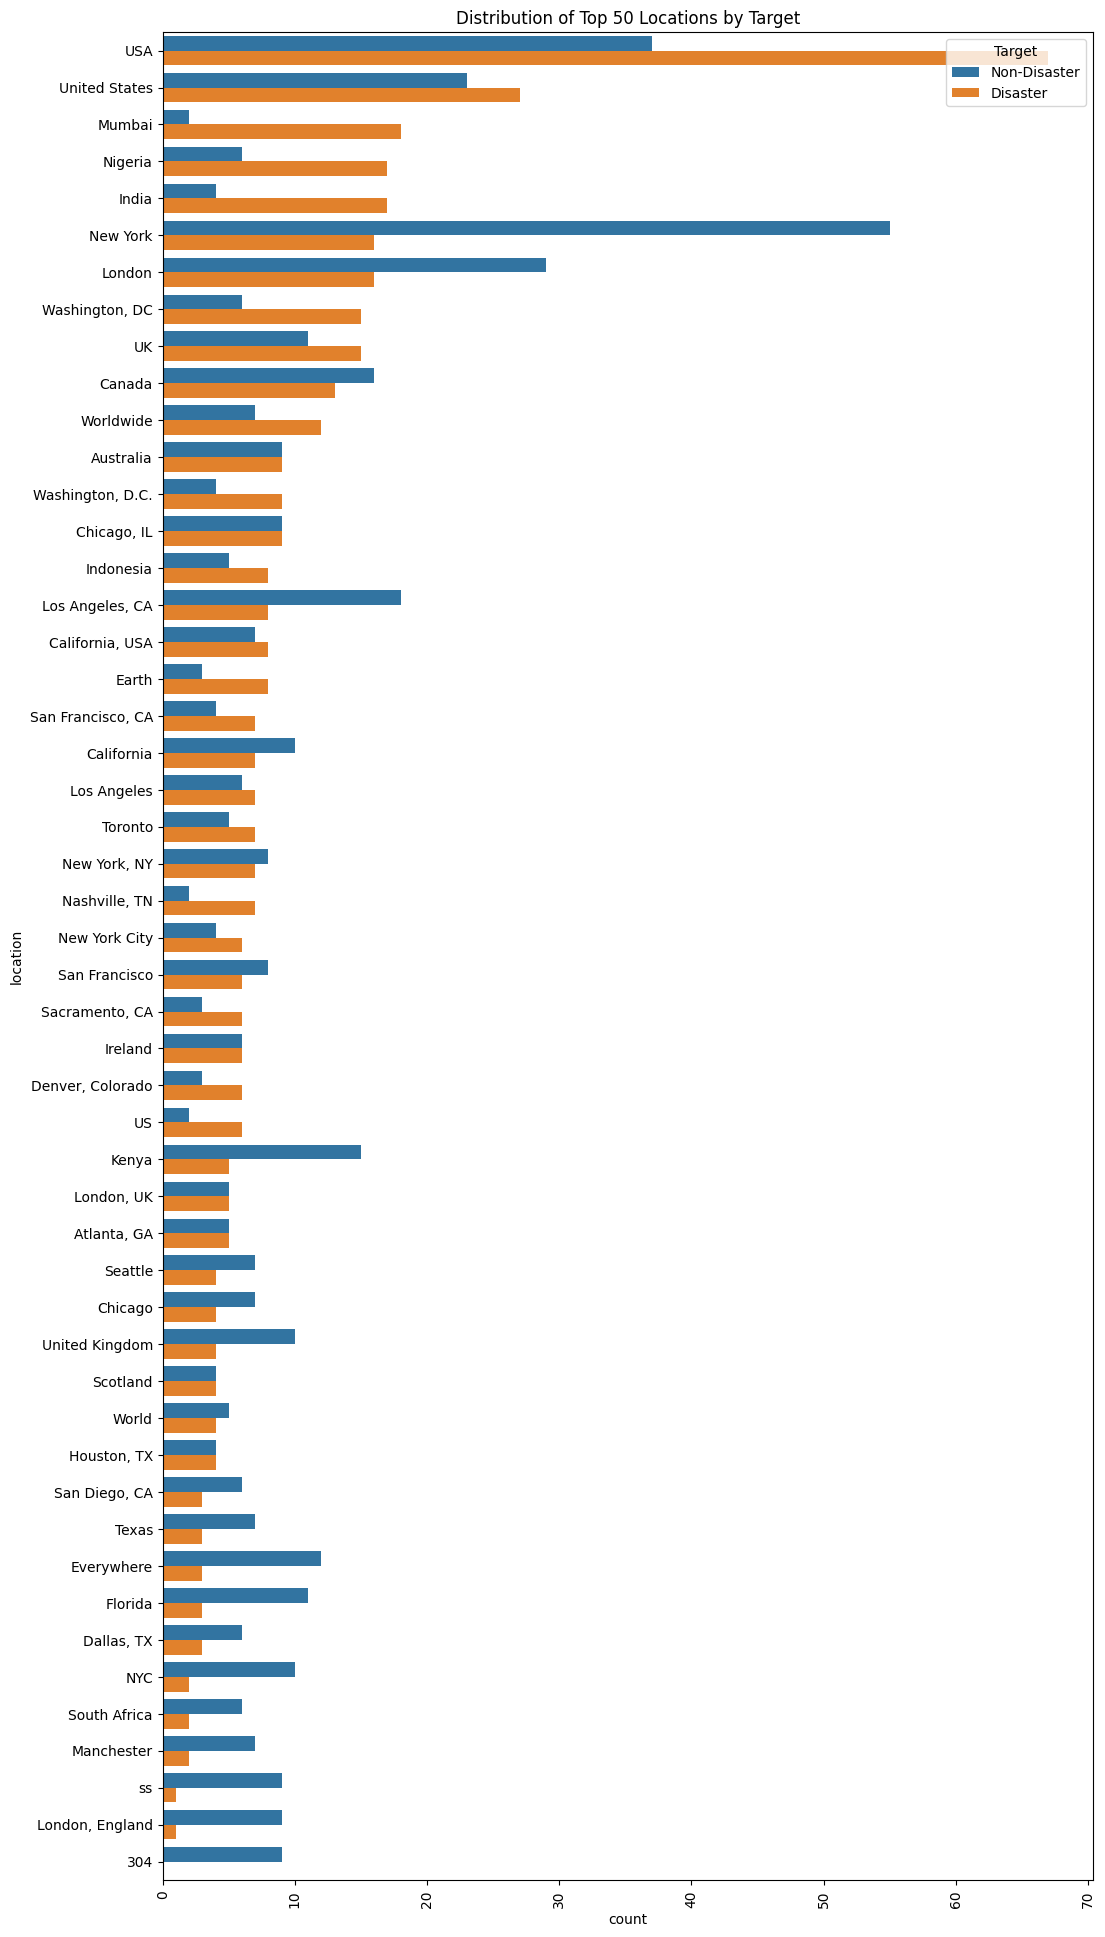

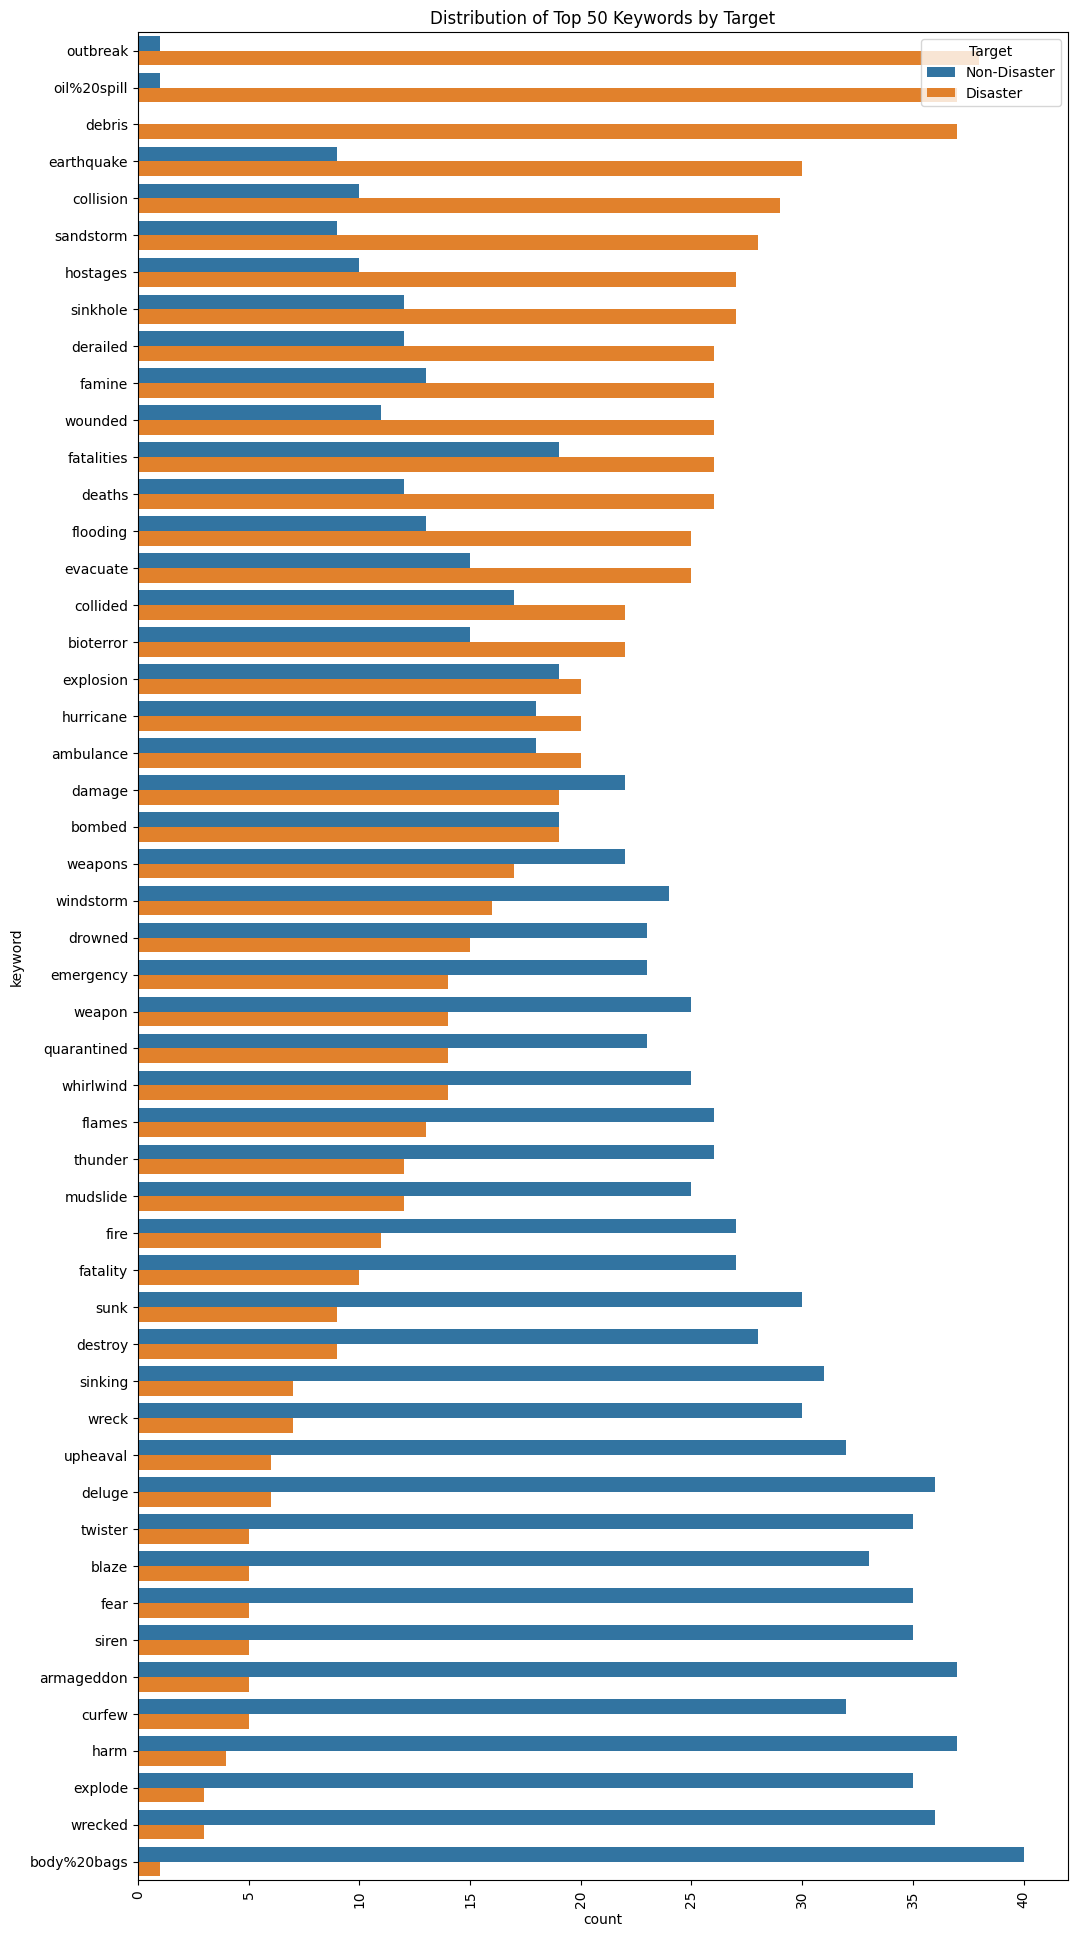

In [ ]:
def plot_categorical(df, col, target, topN=50):
    top_categories = df[col].value_counts().index[:topN]

    df_topN = df[df[col].isin(top_categories)]
    plt.figure(figsize=(12,24))

    # Calculate counts of each category for each target class
    counts = df_topN.groupby([col, target]).size().unstack(fill_value=0)
    # Sort categories by count of 'Disaster' target class
    sorted_categories = counts.sort_values(by=1, ascending=False).index

    # Plot distribution of feature for each target class
    sns.countplot(data=df_topN, y=col, hue=target, order=sorted_categories)
    plt.xticks(rotation=90)
    plt.title(f"Distribution of Top {topN} {col.capitalize()}s by Target")

    # Create a custom legend
    legend_labels = ['Non-Disaster', 'Disaster']
    plt.legend(title='Target', loc='upper right', labels=legend_labels)

    plt.show()

plot_categorical(train, 'location', 'target')
plot_categorical(train, 'keyword', 'target')


In [ ]:
from sklearn.preprocessing import LabelEncoder

test = pd.read_csv('test.csv')

# Fill NaNs with a placeholder string
train['keyword'].fillna('missing', inplace=True)
train['location'].fillna('missing', inplace=True)

# Fill NaNs with a placeholder string
test['keyword'].fillna('missing', inplace=True)
test['location'].fillna('missing', inplace=True)

# Define a function to handle unseen labels
def handle_unseen_labels(train_series, test_series):
    train_unique_labels = set(train_series.dropna())
    test_series[~test_series.isin(train_unique_labels)] = 'missing'
    return test_series

# Apply the function to the test data
test['keyword'] = handle_unseen_labels(train['keyword'], test['keyword'])
test['location'] = handle_unseen_labels(train['location'], test['location'])

# Now you can fit the LabelEncoder on the train data and transform the test data
keyword_encoder = LabelEncoder().fit(train['keyword'].astype(str))
location_encoder = LabelEncoder().fit(train['location'].astype(str))

# Transform the train and test data
train['keyword_encoded'] = keyword_encoder.transform(train['keyword'].astype(str))
test['keyword_encoded'] = keyword_encoder.transform(test['keyword'].astype(str))

train['location_encoded'] = location_encoder.transform(train['location'].astype(str))
test['location_encoded'] = location_encoder.transform(test['location'].astype(str))


<ipython-input-19-a73b010ffb60>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_series[~test_series.isin(train_unique_labels)] = 'missing'


### SCALE THE FEATURES AND ADD KEYWORD AND LOCATION FEATURES TO THEM

In [ ]:
train

,text,id,keyword,location,tweet_length,word_count,unique_word_count,stop_word_count,mean_word_length,char_count,...,mentions_count,urls_count,uppercase_word_count,sentiment,target,tokenized_text,processed_text,topic,keyword_encoded,location_encoded
0,! Residents Return To Destroyed Homes As Washi...,10517,wildfire,missing,92,12,12,3,6.750000,92,...,0,1,0,0.000000,1,"[resident, return, to, destroyed, home, a, was...",resident return to destroyed home a washington...,14,215,3111
1,# handbags Genuine Mulberry Antony Cross Body ...,1383,body%20bag,missing,137,18,18,0,6.611111,137,...,0,1,1,0.087500,0,"[handbag, genuine, mulberry, antony, cross, bo...",handbag genuine mulberry antony cross body mes...,17,27,3111
2,#360WiseNews : China's Stock Market Crash: Are...,8314,rubble,London,95,13,13,4,6.384615,95,...,0,1,0,0.000000,1,"[<number>wisenews, china, stock, market, crash...",<number>wisenews china stock market crash are ...,17,170,1501
3,#360WiseNews : China's Stock Market Crash: Are...,8334,rubble,Made Here In Detroit,95,13,13,4,6.384615,95,...,0,1,0,0.000000,1,"[<number>wisenews, china, stock, market, crash...",<number>wisenews china stock market crash are ...,17,170,1574
4,#360WiseNews : China's Stock Market Crash: Are...,8301,rubble,"Accra,Ghana",95,13,13,4,6.384615,95,...,0,1,0,0.000000,0,"[<number>wisenews, china, stock, market, crash...",<number>wisenews china stock market crash are ...,17,170,232
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7498,Û÷We Can HelpÛª Says Denver Firefighter Work...,5420,first%20responders,"Portage, IN / Worldwide",104,13,13,2,7.076923,104,...,0,1,0,0.250000,1,"[û÷we, can, helpûª, say, denver, firefighter...",û÷we can helpûª say denver firefighter worki...,7,109,2093
7499,å_? New Ladies Shoulder Tote #Handbag Faux Lea...,1414,body%20bag,Paignton,130,16,16,0,7.187500,130,...,0,2,0,0.068182,0,"[å, new, lady, shoulder, tote, handbag, faux, ...",å new lady shoulder tote handbag faux leather ...,4,27,1996
7500,å¤} New Ladies Shoulder Tote #Handbag Faux Lea...,1394,body%20bag,"California, USA",139,18,18,0,6.777778,139,...,0,2,1,0.068182,0,"[å¤, new, lady, shoulder, tote, handbag, faux,...",å¤ new lady shoulder tote handbag faux leather...,4,27,573
7501,å¬'Only the sea knows how many are dead' @MSF_...,4006,disaster,missing,135,19,19,7,6.105263,135,...,1,1,0,0.075000,1,"[å¬only, the, sea, know, how, many, are, dead,...",å¬only the sea know how many are dead after la...,2,80,3111


In [ ]:
scaler = StandardScaler()
train_features = train.drop(['id', 'text', 'keyword', 'location', 'target', 'tokenized_text', 'processed_text'], axis=1)
train_features_scaled = scaler.fit_transform(train_features)

### DEFINING THE DisasterTweetDataset CLASS

In [ ]:
class DisasterTweetDataset(Dataset):
  def __init__(self, tweets, features, tokenizer, max_length, labels=None):
    self.tweets = tweets
    self.features = features
    self.labels = labels
    self.tokenizer = tokenizer
    self.max_length = max_length
  def __len__(self):
    return len(self.tweets)

  def __getitem__(self, idx):
      tweet = self.tweets[idx]
      feature = self.features[idx]
      encoding = self.tokenizer.encode_plus(
          tweet,
          add_special_tokens=True,
          max_length=self.max_length,
          return_token_type_ids=False,
          padding='max_length',
          truncation=True,
          return_attention_mask=True,
          return_tensors='pt',
      )

      item = {
          'tweet': tweet,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'features': torch.tensor(feature, dtype=torch.float)
      }

      if self.labels is not None:
          label = self.labels[idx]
          item['label'] = torch.tensor(label, dtype=torch.long)

      return item


### DEFINING THE EVALUATE FUNCTION

In [ ]:
def evaluate(model, dataloader, device):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            features = batch['features'].to(device)
            labels = batch['label'].to(device)

            logits = model(input_ids=input_ids, attention_mask=attention_mask, features=features)
            _, preds = torch.max(logits, dim=1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    metrics = compute_metrics(y_true, y_pred)
    return metrics

### PREPARING THE DATALOADERS

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(train.drop('target', axis=1), train['target'], test_size=0.2, random_state=42)

tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')
max_length = 128
batch_size = 16
train_dataset = DisasterTweetDataset(X_train['text'].values, train_features_scaled[X_train.index], tokenizer, max_length, y_train.values)
val_dataset = DisasterTweetDataset(X_val['text'].values, train_features_scaled[X_val.index], tokenizer, max_length, y_val.values)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

### DEFINING THE MODEL AND MOVING IT TO DEVICE

In [ ]:
class BertWithFeatures(nn.Module):
  def __init__(self, base_model, num_labels, num_features):
    super().__init__()
    self.base_model = base_model
    self.dropout = nn.Dropout(0.1)
    self.classifier = nn.Linear(base_model.config.hidden_size + num_features, num_labels)

  def forward(self, input_ids, attention_mask, features):
    base_output = self.base_model(input_ids=input_ids, attention_mask=attention_mask)
    pooled_output = base_output.pooler_output
    concat_output = torch.cat([pooled_output, features], dim=1)
    dropout_output = self.dropout(concat_output)
    logits = self.classifier(dropout_output)
    return logits




base_model = BertModel.from_pretrained('bert-large-uncased')

num_labels = 2
num_features = train_features_scaled.shape[1]
model = BertWithFeatures(base_model, num_labels, num_features)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

Downloading:   0%|          | 0.00/1.25G [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertWithFeatures(
  (base_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1e-12, e

### SETTING UP THE OPTIMIZED, SCHEDULER, AND METRICS FUNCTION

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-5)
epochs = 1
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader) * epochs)

from sklearn.metrics import f1_score

def compute_metrics(y_true, y_pred):
    # Calculate the F1 score
    f1 = f1_score(y_true, y_pred, average='weighted')
    return {"f1": f1}

### TRAIN THE MODEL AND EVALUATE IT

In [ ]:
for epoch in range(epochs):
  model.train()
  step = 0
  for batch in train_dataloader:
    step +=1
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    features = batch['features'].to(device)
    labels = batch['label'].to(device)
    model.zero_grad()
    logits = model(input_ids=input_ids, attention_mask=attention_mask, features=features)
    loss = nn.CrossEntropyLoss()(logits, labels)
    loss.backward()
    optimizer.step()
    scheduler.step()

    # Evaluate the model after each step
    #val_metrics = evaluate(model, val_dataloader, device)
    #print(f"Step: {step}, Accuracy: {val_metrics['accuracy']:.4f}")

metrics = evaluate(model, val_dataloader, device)
print(metrics)


{'f1': 0.8306527679152478}


### PLOT THE ROC AND PRECISION-RECALL CURVES

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve


# Get the predicted probabilities for the positive class
model.eval()
y_true, y_pred_probs = [], []

with torch.no_grad():
    for batch in val_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        features = batch['features'].to(device)
        labels = batch['label'].to(device)

        logits = model(input_ids=input_ids, attention_mask=attention_mask, features=features)
        _, preds = torch.max(logits, dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred_probs.extend(torch.softmax(logits, dim=1)[:, 1].cpu().numpy())

# Compute the false positive rate (fpr), true positive rate (tpr), and thresholds
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)

# Compute the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

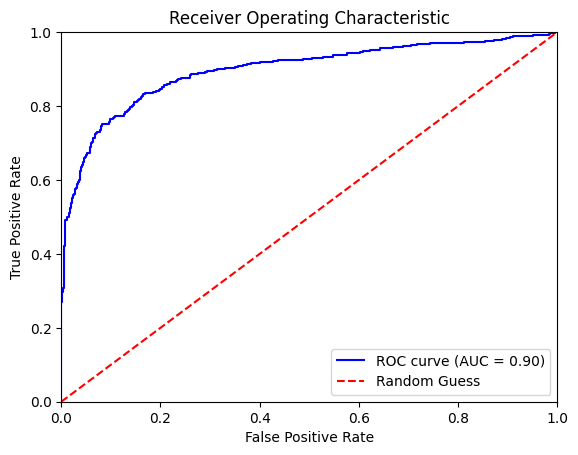

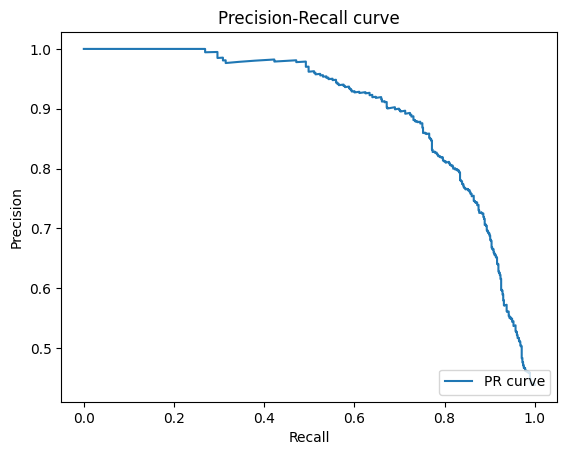

In [ ]:
# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='b', label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='r', linestyle='--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

precision, recall, _ = precision_recall_curve(y_true, y_pred_probs)
plt.plot(recall, precision, label='PR curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc="lower right")
plt.show()

### CONFUSION MATRIX

In [ ]:
from sklearn.metrics import confusion_matrix

# Get the predicted labels
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for batch in val_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        features = batch['features'].to(device)
        labels = batch['label'].to(device)

        logits = model(input_ids=input_ids, attention_mask=attention_mask, features=features)
        _, preds = torch.max(logits, dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[739 104]
 [149 509]]


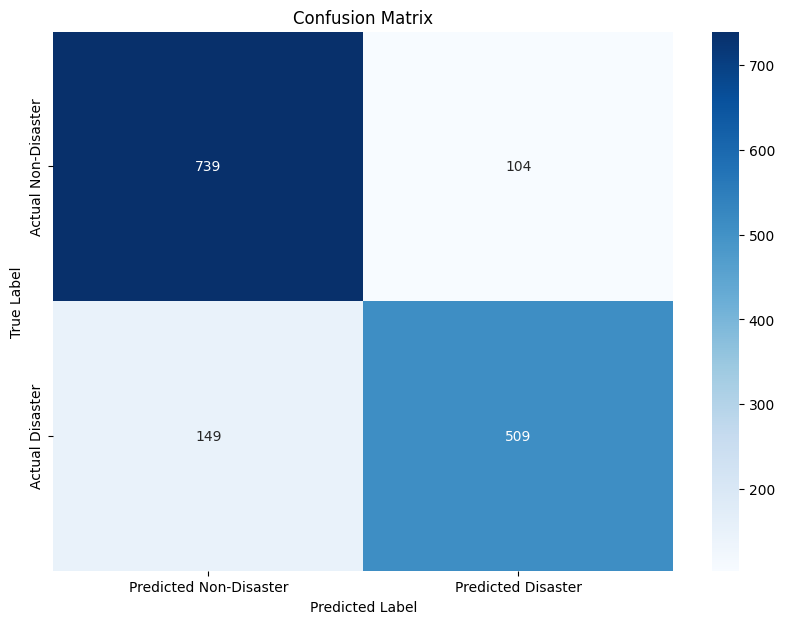

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a DataFrame from the confusion matrix
cm_df = pd.DataFrame(cm, index=['Actual Non-Disaster', 'Actual Disaster'], columns=['Predicted Non-Disaster', 'Predicted Disaster'])

plt.figure(figsize=(10,7))

sns.heatmap(cm_df, annot=True, fmt='g', cmap='Blues')
plt.title("Confusion Matrix")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


### MAKE PREDICTIONS ON TEST SET

In [ ]:
scaler.feature_names_in_

array(['tweet_length', 'word_count', 'unique_word_count',
       'stop_word_count', 'mean_word_length', 'char_count',
       'punctuation_count', 'hashtag_count', 'hashtags_count',
       'mentions_count', 'urls_count', 'uppercase_word_count',
       'sentiment', 'topic', 'keyword_encoded', 'location_encoded'],
      dtype=object)

In [ ]:
# Preprocess the test dataset text
test['processed_text'] = test['text'].apply(preprocess).apply(lambda x: ' '.join(x))

# Transform the test text using the same vectorizer used on the train dataset

test = extract_features(test)

X_test = vectorizer.transform(test['text'])
# Assign a topic to each tweet using the same LDA model fitted on the train dataset
test['topic'] = lda.transform(X_test).argmax(axis=1)

# Include these encoded columns in your features
test_features = test.drop(['id', 'text', 'keyword', 'location', "processed_text"], axis=1)

# Get the column names
columns = test_features.columns.tolist()

# Move the first two columns to the end
columns = columns[2:] + columns[:2]

# Reorder the DataFrame columns
test_features = test_features[columns]


test_features_scaled = scaler.transform(test_features)


# Update the DisasterTweetDataset call for the test dataset to use 'processed_text' instead of 'text'
test_dataset = DisasterTweetDataset(test['text'].values, test_features_scaled, tokenizer, max_length)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
def predict(model, dataloader, device):
    model.eval()
    predictions = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            features = batch['features'].to(device)

            logits = model(input_ids=input_ids, attention_mask=attention_mask, features=features)
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            predictions.extend(preds)

    return predictions



test_predictions = predict(model, test_dataloader, device)


In [ ]:
# Save the predictions to a CSV file
submission = pd.DataFrame({"id": test["id"], "target": test_predictions})
submission.to_csv("submission16_last.csv", index=False)

### ELMo implementation from here ----->>>>

In [ ]:
import pandas as pd
import re
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
import string
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from allennlp.modules.elmo import Elmo, batch_to_ids
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.preprocessing import StandardScaler

batch_size = 16
scaler = StandardScaler()
train_features = train.drop(['id', 'text', 'keyword', 'location', 'target'], axis=1)
train_features_scaled = scaler.fit_transform(train_features)


def evaluate(model, dataloader, device):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for batch in dataloader:
            char_ids = batch['char_ids'].to(device)
            features = batch['features'].to(device)
            labels = batch['label'].to(device)

            logits = model(char_ids=char_ids, features=features)
            _, preds = torch.max(logits, dim=1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    metrics = compute_metrics(y_true, y_pred)
    return metrics


def text_to_character_ids(text, max_length=128):  # We set a default value for max_length
    character_ids = batch_to_ids([text.split()]).squeeze(0)
    padded_character_ids = torch.zeros((max_length, 50), dtype=torch.long)
    seq_length = min(max_length, character_ids.size(0))
    padded_character_ids[:seq_length] = character_ids[:seq_length]
    return padded_character_ids






class DisasterTweetDataset(Dataset):
    def __init__(self, tweets, features, tokenizer, labels=None):
        self.tweets = tweets
        self.features = features
        self.labels = labels
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.tweets)

    def __getitem__(self, idx):
        tweet = self.tweets[idx]
        feature = self.features[idx]
        char_ids = text_to_character_ids(tweet)

        item = {
            'tweet': tweet,
            'char_ids': char_ids,
            'features': torch.tensor(feature, dtype=torch.float),
        }

        if self.labels is not None:
            label = self.labels[idx]
            item['label'] = torch.tensor(label, dtype=torch.long)

        return item


# Replace BertTokenizer with ELMo
max_length = 128
options_file = "https://allennlp.s3.amazonaws.com/models/elmo/2x4096_512_2048cnn_2xhighway/elmo_2x4096_512_2048cnn_2xhighway_options.json"
weight_file = "https://allennlp.s3.amazonaws.com/models/elmo/2x4096_512_2048cnn_2xhighway/elmo_2x4096_512_2048cnn_2xhighway_weights.hdf5"
elmo = Elmo(options_file, weight_file, num_output_representations=1, dropout=0, requires_grad=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
elmo = elmo.to(device)


X_train, X_val, y_train, y_val = train_test_split(train.drop('target', axis=1), train['target'], test_size=0.2, random_state=42)




class ElmoWithFeatures(nn.Module):
    def __init__(self, elmo, num_labels, num_features):
        super().__init__()
        self.elmo = elmo
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(1024 + num_features, num_labels)

    def forward(self, char_ids, features):
        elmo_output = self.elmo(char_ids)['elmo_representations'][0].mean(dim=1)
        concat_output = torch.cat([elmo_output, features], dim=1)
        dropout_output = self.dropout(concat_output)
        logits = self.classifier(dropout_output)
        return logits

# Replace BertModel with ELMo
num_labels = 2
num_features = train_features_scaled.shape[1]
model = ElmoWithFeatures(elmo, num_labels, num_features)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=3e-5)
epochs = 1

# Create the training and validation datasets
train_dataset = DisasterTweetDataset(X_train['text'].values, train_features_scaled[X_train.index], max_length, y_train.values)
val_dataset = DisasterTweetDataset(X_val['text'].values, train_features_scaled[X_val.index], max_length, y_val.values)

# Define the dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Now we can define the scheduler
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader) * epochs)


def compute_metrics(y_true, y_pred):
    # Add any additional metrics here
    accuracy = accuracy_score(y_true, y_pred)
    return {"accuracy": accuracy}

for epoch in range(epochs):
    model.train()
    step = 0
    for batch in train_dataloader:
        step += 1
        char_ids = batch['char_ids'].to(device)
        features = batch['features'].to(device)
        labels = batch['label'].to(device)
        model.zero_grad()
        logits = model(char_ids=char_ids, features=features)
        loss = nn.CrossEntropyLoss()(logits, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        # Evaluate the model after each step
        # val_metrics = evaluate(model, val_dataloader, device)
        # print(f"Step: {step}, Accuracy: {val_metrics['accuracy']:.4f}")



In [ ]:
def evaluate(model, dataloader, device):
    model.eval()
    y_true, y_pred, y_probs = [], [], []

    with torch.no_grad():
        for batch in dataloader:
            char_ids = batch['char_ids'].to(device)
            features = batch['features'].to(device)
            labels = batch['label'].to(device)

            logits = model(char_ids=char_ids, features=features)
            probs = torch.nn.functional.softmax(logits, dim=1)
            _, preds = torch.max(logits, dim=1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_probs.extend(probs.cpu().numpy())

    metrics = compute_metrics(y_true, y_pred)
    return metrics, y_true, y_probs



val_metrics, y_true, y_probs = evaluate(model, val_dataloader, device)
elmo_probs = [prob[1] for prob in y_probs]

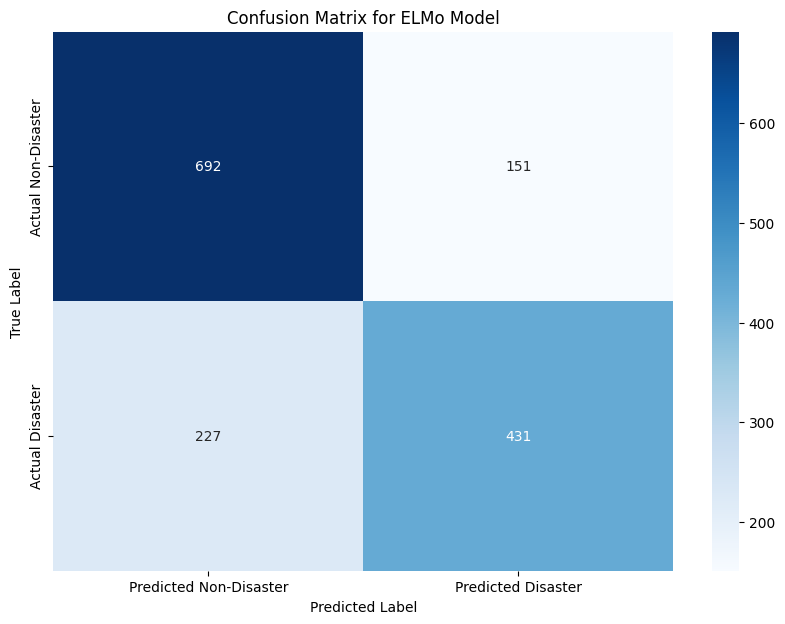

In [ ]:
# Compute predicted labels
elmo_pred = [1 if prob > 0.5 else 0 for prob in elmo_probs]
# Compute the confusion matrix
cm_elmo = confusion_matrix(y_true, elmo_pred)

# Create a DataFrame from the confusion matrix
cm_df_elmo = pd.DataFrame(cm_elmo, index=['Actual Non-Disaster', 'Actual Disaster'], columns=['Predicted Non-Disaster', 'Predicted Disaster'])

plt.figure(figsize=(10,7))

# Create a heatmap from the DataFrame
sns.heatmap(cm_df_elmo, annot=True, fmt='g', cmap='Blues')
plt.title("Confusion Matrix for ELMo Model")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


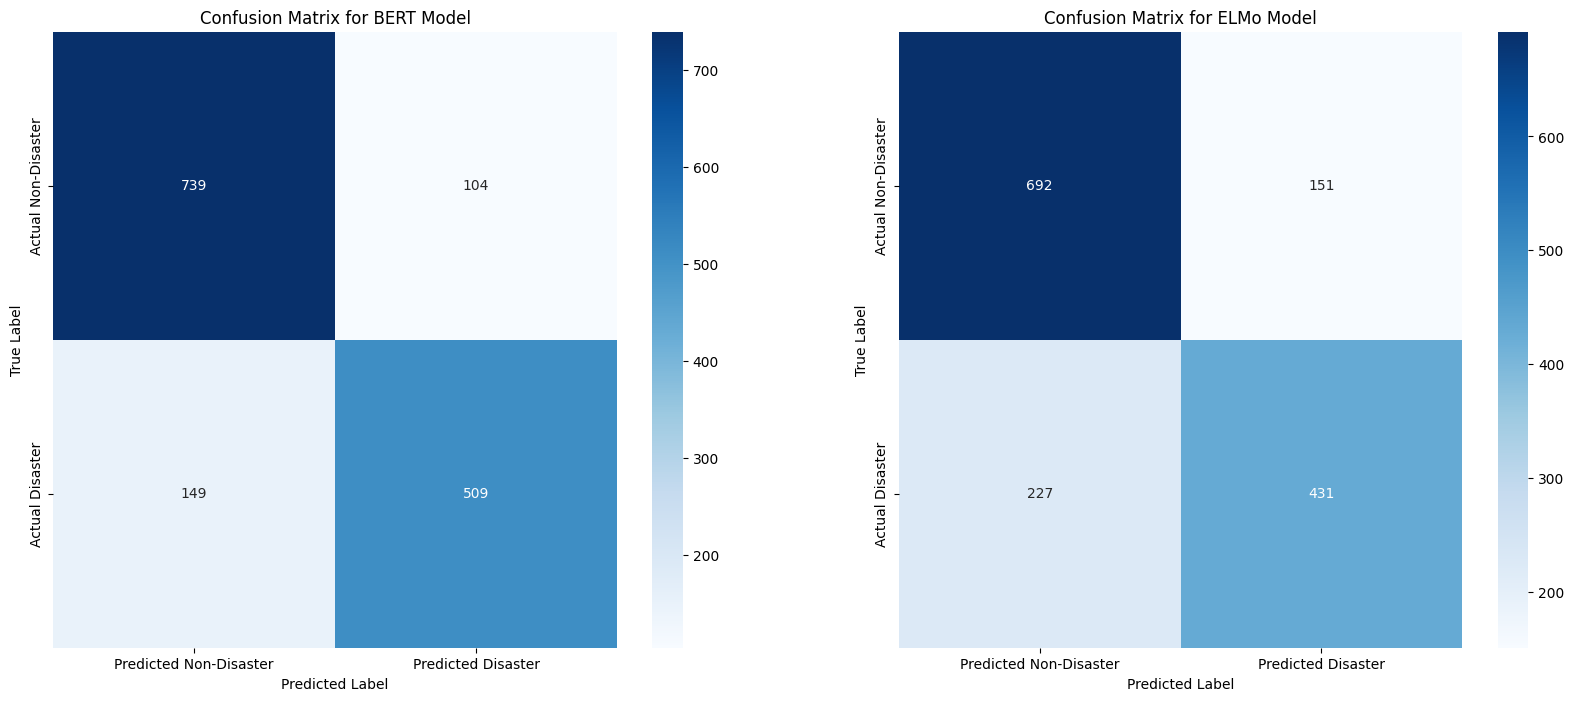

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming cm_bert is your confusion matrix for BERT model
cm_df_bert = pd.DataFrame(cm, index=['Actual Non-Disaster', 'Actual Disaster'], columns=['Predicted Non-Disaster', 'Predicted Disaster'])

# Assuming cm_elmo is your confusion matrix for ELMo model
cm_df_elmo = pd.DataFrame(cm_elmo, index=['Actual Non-Disaster', 'Actual Disaster'], columns=['Predicted Non-Disaster', 'Predicted Disaster'])

fig, ax = plt.subplots(1, 2, figsize=(20,8))

sns.heatmap(cm_df_bert, annot=True, fmt='g', cmap='Blues', ax=ax[0])
ax[0].set_title('Confusion Matrix for BERT Model')
ax[0].set_ylabel('True Label')
ax[0].set_xlabel('Predicted Label')

sns.heatmap(cm_df_elmo, annot=True, fmt='g', cmap='Blues', ax=ax[1])
ax[1].set_title('Confusion Matrix for ELMo Model')
ax[1].set_ylabel('True Label')
ax[1].set_xlabel('Predicted Label')

plt.show()


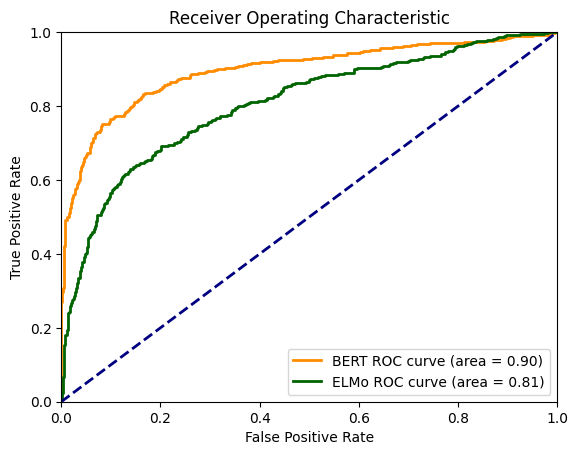

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area for each class
bert_fpr, bert_tpr, _ = roc_curve(y_true, y_pred_probs)
bert_roc_auc = auc(bert_fpr, bert_tpr)

elmo_fpr, elmo_tpr, _ = roc_curve(y_true, elmo_probs)
elmo_roc_auc = auc(elmo_fpr, elmo_tpr)

# Plot the ROC curve
plt.figure()
lw = 2  # line width
plt.plot(bert_fpr, bert_tpr, color='darkorange', lw=lw, label='BERT ROC curve (area = %0.2f)' % bert_roc_auc)
plt.plot(elmo_fpr, elmo_tpr, color='darkgreen', lw=lw, label='ELMo ROC curve (area = %0.2f)' % elmo_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')  # diagonal line for reference
plt.xlim([0.0, 1.0])  # x-axis limits
plt.ylim([0.0, 1.0])  # y-axis limits
plt.xlabel('False Positive Rate')  # x-axis label
plt.ylabel('True Positive Rate')  # y-axis label
plt.title('Receiver Operating Characteristic')  # plot title
plt.legend(loc="lower right")  # legend location
plt.show()


In [ ]:
scaler.feature_names_in_

array(['tweet_length', 'word_count', 'unique_word_count',
       'stop_word_count', 'mean_word_length', 'char_count',
       'punctuation_count', 'hashtag_count', 'hashtags_count',
       'mentions_count', 'urls_count', 'uppercase_word_count',
       'sentiment', 'topic', 'keyword_encoded', 'location_encoded'],
      dtype=object)

In [ ]:
test

,id,keyword,location,text,keyword_encoded,location_encoded
0,0,missing,missing,Just happened a terrible car crash,145,3119
1,2,missing,missing,"Heard about #earthquake is different cities, s...",145,3119
2,3,missing,missing,"there is a forest fire at spot pond, geese are...",145,3119
3,9,missing,missing,Apocalypse lighting. #Spokane #wildfires,145,3119
4,11,missing,missing,Typhoon Soudelor kills 28 in China and Taiwan,145,3119
...,...,...,...,...,...,...
3258,10861,missing,missing,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,145,3119
3259,10865,missing,missing,Storm in RI worse than last hurricane. My city...,145,3119
3260,10868,missing,missing,Green Line derailment in Chicago http://t.co/U...,145,3119
3261,10874,missing,missing,MEG issues Hazardous Weather Outlook (HWO) htt...,145,3119


In [ ]:
def predict(model, dataloader, device):
    model.eval()
    predictions = []

    with torch.no_grad():
        for batch in dataloader:
            char_ids = batch['char_ids'].to(device)
            features = batch['features'].to(device)

            logits = model(char_ids=char_ids, features=features)
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            predictions.extend(preds)

    return predictions




#test = pd.read_csv('test.csv')

# Preprocess the test dataset text
#test['processed_text'] = test['text'].apply(preprocess).apply(lambda x: ' '.join(x))

# Transform the test text using the same vectorizer used on the train dataset

test = extract_features(test)

X_test = vectorizer.transform(test['text'])
# Assign a topic to each tweet using the same LDA model fitted on the train dataset
test['topic'] = lda.transform(X_test).argmax(axis=1)

test_features = test.drop(['id', 'text', 'keyword', 'location'], axis=1)
# Get the column names
columns = test_features.columns.tolist()

# Move the first two columns to the end
columns = columns[2:] + columns[:2]

# Reorder the DataFrame columns
test_features = test_features[columns]
test_features_scaled = scaler.transform(test_features)

# Update the DisasterTweetDataset call for the test dataset to use 'processed_text' instead of 'text'
test_dataset = DisasterTweetDataset(test['text'].values, test_features_scaled, max_length)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

test_predictions = predict(model, test_dataloader, device)


In [ ]:
# Save the predictions to a CSV file
submission = pd.DataFrame({"id": test["id"], "target": test_predictions})
submission.to_csv("submission21_ELMo.csv", index=False)

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from allennlp.modules.elmo import Elmo, batch_to_ids
from sklearn.model_selection import train_test_split
from transformers import AdamW, get_linear_schedule_with_warmup
import pandas as pd

class DisasterTweetDataset(Dataset):
    def __init__(self, tweets, labels=None):
        self.tweets = tweets
        self.labels = labels

    def __len__(self):
        return len(self.tweets)

    def __getitem__(self, idx):
        tweet = self.tweets[idx]
        char_ids = self.text_to_character_ids(tweet)

        item = {'char_ids': char_ids}

        if self.labels is not None:
            label = self.labels[idx]
            item['label'] = torch.tensor(label, dtype=torch.long)

        return item

    @staticmethod
    def text_to_character_ids(text, max_length=128):
        character_ids = batch_to_ids([text.split()]).squeeze(0)
        padded_character_ids = torch.zeros((max_length, 50), dtype=torch.long)
        seq_length = min(max_length, character_ids.size(0))
        padded_character_ids[:seq_length] = character_ids[:seq_length]
        return padded_character_ids


class ElmoClassifier(nn.Module):
    def __init__(self, elmo, num_labels):
        super().__init__()
        self.elmo = elmo
        self.classifier = nn.Linear(1024, num_labels)

    def forward(self, char_ids):
        elmo_output = self.elmo(char_ids)['elmo_representations'][0].mean(dim=1)
        logits = self.classifier(elmo_output)
        return logits


# Load the data
train = pd.read_csv('train.csv')
X_train, X_val, y_train, y_val = train_test_split(train['text'], train['target'], test_size=0.2, random_state=42)

# Create ELMo
options_file = "https://allennlp.s3.amazonaws.com/models/elmo/2x4096_512_2048cnn_2xhighway/elmo_2x4096_512_2048cnn_2xhighway_options.json"
weight_file = "https://allennlp.s3.amazonaws.com/models/elmo/2x4096_512_2048cnn_2xhighway/elmo_2x4096_512_2048cnn_2xhighway_weights.hdf5"
elmo = Elmo(options_file, weight_file, num_output_representations=1, dropout=0, requires_grad=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
elmo = elmo.to(device)

# Define the model, optimizer, and scheduler
model = ElmoClassifier(elmo, num_labels=2)
model.to(device)
optimizer = AdamW(model.parameters(), lr=3e-5)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(X_train))

# Define the dataloaders
train_dataset = DisasterTweetDataset(X_train.values, y_train.values)
val_dataset = DisasterTweetDataset(X_val.values, y_val.values)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Train the model
epochs = 1
for epoch in range(epochs):
    model.train()
    for batch in train_dataloader:
        char_ids = batch['char_ids'].to(device)
        labels = batch['label'].to(device)
        model.zero_grad()

        logits = model(char_ids=char_ids)
        loss = nn.CrossEntropyLoss()(logits, labels)

        loss.backward()
        optimizer.step()
        scheduler.step()

    # Validate the model after each epoch
    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        for batch in val_dataloader:
            char_ids = batch['char_ids'].to(device)
            labels = batch['label'].to(device)

            logits = model(char_ids=char_ids)
            _, predicted = torch.max(logits.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy after epoch {epoch + 1}: {correct / total:.2f}')



Output()

Output()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Accuracy after epoch 1: 0.82


In [ ]:
def predict(model, dataloader, device):
    model.eval()
    predictions = []

    with torch.no_grad():
        for batch in dataloader:
            char_ids = batch['char_ids'].to(device)

            logits = model(char_ids=char_ids)
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            predictions.extend(preds)

    return predictions

# Load the test data
test = pd.read_csv('test.csv')

# Create the test dataset and dataloader
test_dataset = DisasterTweetDataset(test['text'].values)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Predict the labels for the test dataset
test_predictions = predict(model, test_dataloader, device)
submission = pd.DataFrame({"id": test["id"], "target": test_predictions})
submission.to_csv("submission20_ELMo.csv", index=False)